## 背景简介

自行车共享系统是租借自行车的一种手段，会员资格的获取，租赁和自行车返回的过程可以通过整个城市的自助服务终端网络自动进行。使用这些系统，人们可以从一个地点租借一辆自行车，并根据需要将其返回到不同的地方。目前，全球共有超过500个自行车共享项目。

研究人员对这些系统生成的数据很感兴趣，因为这些数据包括了旅行的持续时间、出发地点、到达地点和过去的时间。因此，自行车共享系统可以用作传感器网络，以研究城市中的交通运行情况。在本次比赛中，参赛者被要求将历史使用模式与天气数据结合起来，以预测华盛顿地区的自行车租赁需求。

## 任务描述

参赛者需要根据Hadi Fanaee Tork提供的Capital Bikeshare数据集，预测华盛顿地区的自行车租赁数量。

本次比赛提供两年间每小时的租赁数据。训练集由每月的前19天组成，而测试集为每月的20日至月末。参赛者必须预测在测试集中每个小时内租赁的自行车总数。

## 具体步骤

1.

（1）理解各变量意义
- 时间：datetime - hourly date + timestamp 
- 季节：season - 1:spring, 2:summer, 3:fall, 4:winter 
- 节假日：holiday - whether the day is considered a holiday
- 工作日：workingday - whether the day is neither a weekend nor holiday
- 天气：weather 
  - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
  - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
  - 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain +Scattered clouds
  - 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 
- 温度：1temp - temperature in Celsius
- 温度：2atemp - "feels like" temperature in Celsius
- 湿度：humidity - relative humidity
- 风速：windspeed - wind speed
- 未注册用户租车数：casual - number of non-registered user rentals initiated
- 注册用户租车数：registered - number of registered user rentals initiated
- 总租车数：count - number of total rentals

（2）问题理解

已知时间、季节、节假日、工作日、天气、温度、湿度、风速、casual、registered等11个变量，预测每月的20日至月末间每小时的count数。因为count数有无穷多个情况，可知这是一个回归问题。

2.

In [1]:
# 导入常用包
import numpy as np
import pandas as pd
import seaborn as sn
from scipy import stats
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# 读取数据集
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# 概览数据集
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
datetime      10886 non-null object
season        10886 non-null int64
holiday       10886 non-null int64
workingday    10886 non-null int64
weather       10886 non-null int64
temp          10886 non-null float64
atemp         10886 non-null float64
humidity      10886 non-null int64
windspeed     10886 non-null float64
casual        10886 non-null int64
registered    10886 non-null int64
count         10886 non-null int64
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.6+ KB


In [3]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6493 entries, 0 to 6492
Data columns (total 9 columns):
datetime      6493 non-null object
season        6493 non-null int64
holiday       6493 non-null int64
workingday    6493 non-null int64
weather       6493 non-null int64
temp          6493 non-null float64
atemp         6493 non-null float64
humidity      6493 non-null int64
windspeed     6493 non-null float64
dtypes: float64(3), int64(5), object(1)
memory usage: 456.6+ KB


发现训练集有10886个样本，测试集有6493个样本，并且都没有缺失值，都有3种类型的数据：object、int、float
并且测试集比训练集少了3个变量：casual，registered，count

In [4]:
# 合并训练集和测试集
tt = train.append(test) # 测试集缺少的变量自动以NaN填充
tt = tt.reset_index().drop('index', axis=1)
# 查看前5个观测量
tt.head()

/Users/yuanzuo/DataAnalysis/lib/python3.7/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


,atemp,casual,count,datetime,holiday,humidity,registered,season,temp,weather,windspeed,workingday
0,14.395,3.0,16.0,2011-01-01 00:00:00,0,81,13.0,1,9.84,1,0.0,0
1,13.635,8.0,40.0,2011-01-01 01:00:00,0,80,32.0,1,9.02,1,0.0,0
2,13.635,5.0,32.0,2011-01-01 02:00:00,0,80,27.0,1,9.02,1,0.0,0
3,14.395,3.0,13.0,2011-01-01 03:00:00,0,75,10.0,1,9.84,1,0.0,0
4,14.395,0.0,1.0,2011-01-01 04:00:00,0,75,1.0,1,9.84,1,0.0,0


/Users/yuanzuo/DataAnalysis/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


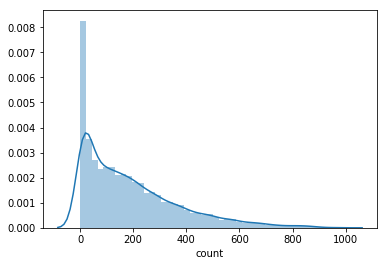

In [5]:
# 对训练集进行简单的分析
# 离散型变量
sn.distplot(train['count'])

从上图可以看出，count变量有点像幂律分布，对于回归问题，我们后期建模预测，目标变量最好是近似正态分布，更有利于预测准确性，所以后面要对其取对数转换。

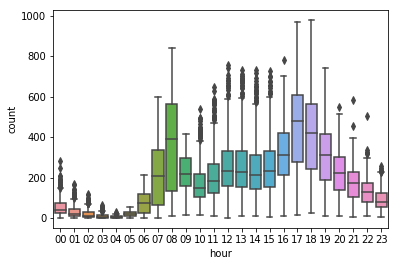

In [6]:
# 一天中各时间段对count的影响
train['hour'] = train['datetime'].str.split(' ', 1, True)[1].str.split(':', 1, True)[0]
sn.boxplot(train['hour'], train['count'])

从上图可以看出，一天中的租赁高峰在早上7-8点和下午17-18点，根据人们的日常生活规律，这两个时间段正好是人们上班上学和下班放学期间，所以hour是需要考虑的特征。

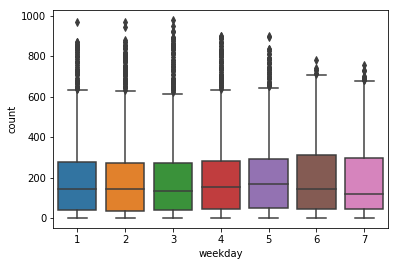

In [7]:
# 一周中各天对count的影响
train['date'] = train['datetime'].str.split(' ', 1, True)[0]
train['weekday'] = pd.to_datetime(train['datetime'], format='%Y-%m-%d').dt.weekday + 1
sn.boxplot(train['weekday'], train['count'])

对于各星期与count的关系，上图不太明显，那就换个展现方式

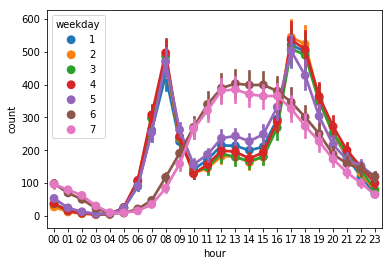

In [8]:
sn.pointplot(x='hour', y='count', hue='weekday', data=train)

这下比较清晰了，星期一到星期五，和周六周日，租赁高峰明显不同，周末两天的10点~17点是租赁高峰期，可能是人们在这个期间陆续外出看电影购物游公园等。

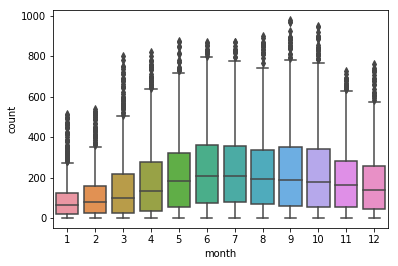

In [9]:
# 各月份对count的影响
train['month'] = pd.to_datetime(train['datetime'], format='%Y-%m-%d').dt.month
sn.boxplot(train['month'], train['count'])

从上图可以看出，各月份对count是有影响的，但相差不大；而与月份有些类似的，我们会联想到季节，季节变量更像是对月份的分箱转换。下面就看看season与count的关系吧：

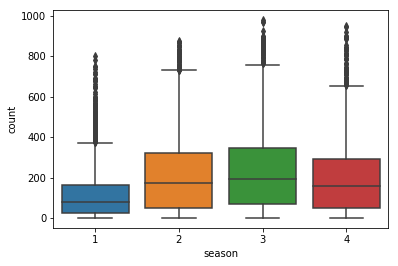

In [10]:
# 不同季节对count的影响
sn.boxplot(train['season'], train['count'])

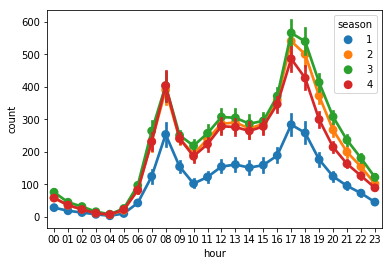

In [11]:
sn.pointplot(x='hour', y='count', hue='season', data=train)

从上面两张图可以看出，夏秋冬三季差距不大，春季相对来说有些少，season和month变量有待取舍。

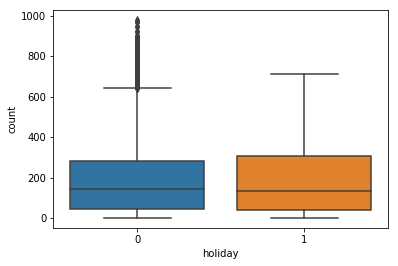

In [12]:
# holiday对count的影响
sn.boxplot(train['holiday'], train['count'])

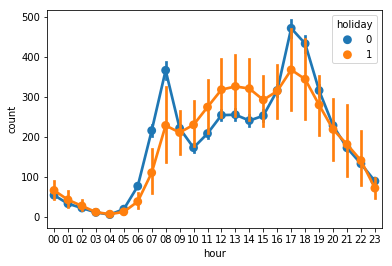

In [13]:
sn.pointplot(x='hour', y='count', hue='holiday', data=train)

holiday与count的分布关系，有些类似一周中各天与count的关系，当是节日时类似周末，不是节日时类似周一到周五。下面看看工作日变量与count关系：

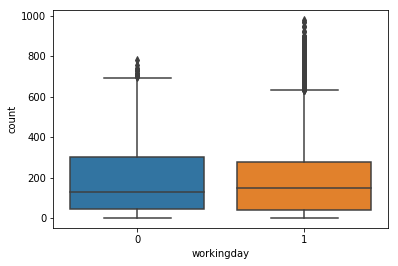

In [14]:
# workingday对count的影响
sn.boxplot(train['workingday'], train['count'])


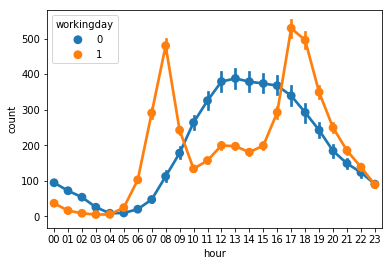

In [15]:
sn.pointplot(x='hour', y='count', hue='workingday', data=train)

果然，workingday与count的关系，非常像一周中各天与count的关系，这意味着workingday与weekday变量可以二选一，holiday变量待取舍。

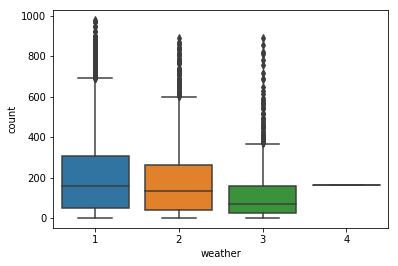

In [16]:
# weather对count的影响
sn.boxplot(train['weather'], train['count'])

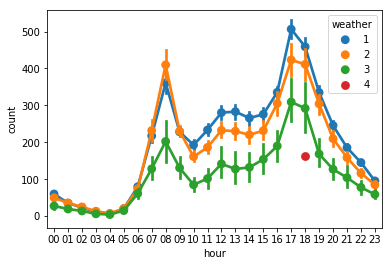

In [17]:
sn.pointplot(x='hour', y='count', hue='weather', data=train)

不用说，天气绝对会影响count，这与我们的常识是一致的：天气越恶劣，count越少

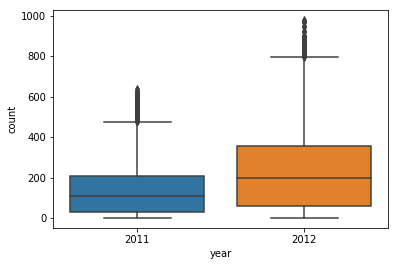

In [18]:
# 年份与count关系
train['year'] = pd.to_datetime(train['datetime'], format='%Y-%m-%d').dt.year
sn.boxplot(train['year'], train['count'])

随着时间变化，count明显是增加的

In [19]:
train.columns

Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count',
       'hour', 'date', 'weekday', 'month', 'year'],
      dtype='object')

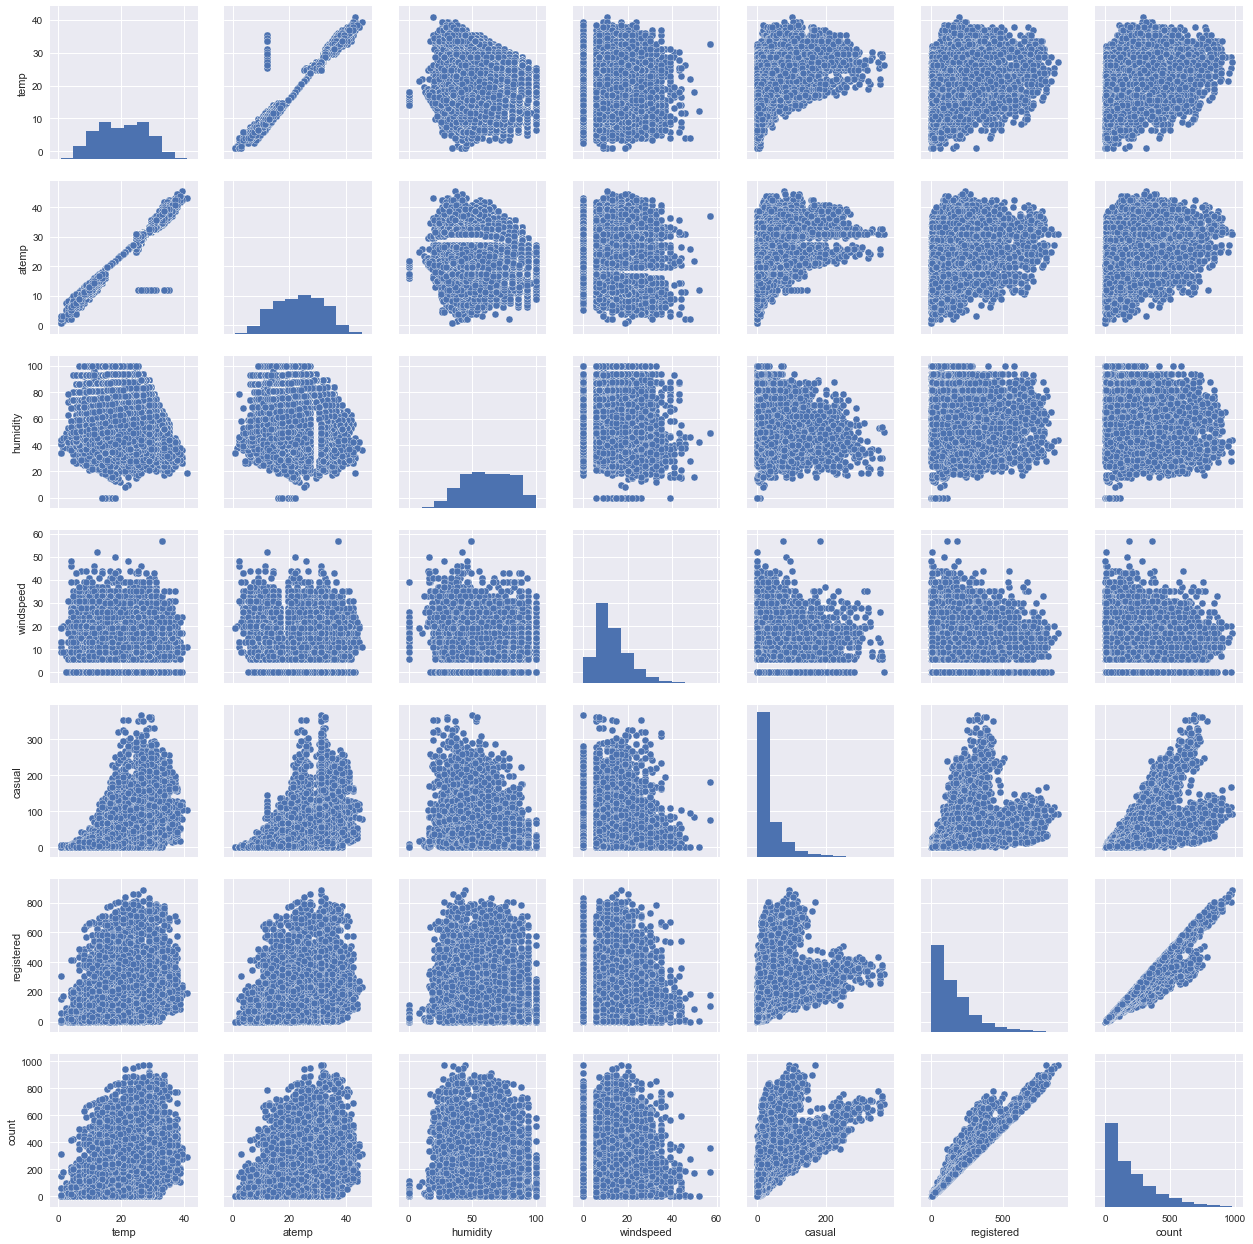

In [20]:
# 连续型变量
sn.set()
cols = ['temp', 'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count']
sn.pairplot(train[cols])

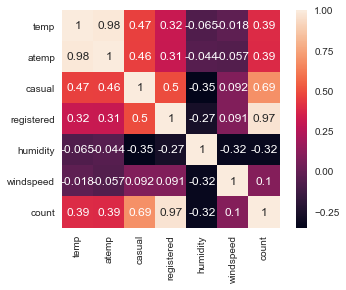

In [21]:
# 皮尔逊相关系数
cor = train[["temp","atemp","casual","registered","humidity","windspeed","count"]].corr()
sn.heatmap(cor, square=True,annot=True)

从皮尔逊相关系数可以看出：

（1）temp和atemp变量高度线性相关，建模时取其一即可；

（2）casual和registered变量，与count线性相关度也很高，但因为测试集中缺少casual和registered变量，并且count=casual+registered，所以还是直接删除它们；

（3）humidity和windspeed变量，从图形中可以看出，基本它们各区间对应的count没有很大差别，并且皮尔逊相关系数也表明是低度相关，所以将直接删除。

综上分析，我们确定的建模变量有：

hour、year、workingday、holiday、season、weather、atemp、count

In [49]:
# 特征工程
# 提取并生成hour、year变量
tt['hour'] = tt['datetime'].str.split(' ', 1, True)[1].str.split(':', 1, True)[0]
tt['year'] = pd.to_datetime(tt['datetime'], format='%Y-%m-%d').dt.year
# 离散型变量转换
tt = pd.get_dummies(tt, columns=['hour'], prefix=['hour'], prefix_sep=' ', drop_first=True)
tt = pd.get_dummies(tt, columns=['year'], prefix=['year'], prefix_sep=' ', drop_first=True)
tt = pd.get_dummies(tt, columns=['season'], prefix=['season'], prefix_sep=' ', drop_first=True)
tt = pd.get_dummies(tt, columns=['weather'], prefix=['weather'], prefix_sep=' ', drop_first=True)
# 删除不要的变量
tt = tt.drop(['temp', 'casual', 'registered', 'datetime', 'humidity', 'windspeed'], axis=1)
tt.head()

,atemp,count,holiday,workingday,hour 01,hour 02,hour 03,hour 04,hour 05,hour 06,...,hour 21,hour 22,hour 23,year 2012,season 2,season 3,season 4,weather 2,weather 3,weather 4
0,14.395,16.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,13.635,40.0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,13.635,32.0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,14.395,13.0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,14.395,1.0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [50]:
# 建模预测
# 从处理后的数据集中提取训练集和测试集
new_train = tt.iloc[:10886]
cols = ['holiday', 'atemp', 'workingday',
        'hour 01', 'hour 02', 'hour 03', 'hour 04', 'hour 05', 'hour 06', 'hour 07', 'hour 08', 'hour 09', 'hour 10', 'hour 11',
        'hour 12', 'hour 13', 'hour 14', 'hour 15', 'hour 16', 'hour 17', 'hour 18', 'hour 19', 'hour 20', 'hour 21', 'hour 22', 'hour 23',
        'year 2012', 'season 2', 'season 3', 'season 4', 'weather 2', 'weather 3', 'weather 4']
x = new_train[cols]
y = np.log1p(new_train['count'])  # 对count+1取对数
new_test = tt.iloc[10886:][cols]
new_test

,holiday,atemp,workingday,hour 01,hour 02,hour 03,hour 04,hour 05,hour 06,hour 07,...,hour 21,hour 22,hour 23,year 2012,season 2,season 3,season 4,weather 2,weather 3,weather 4
10886,0,11.365,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10887,0,13.635,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10888,0,13.635,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10889,0,12.880,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10890,0,12.880,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10891,0,11.365,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
10892,0,10.605,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
10893,0,10.605,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
10894,0,10.605,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10895,0,11.365,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [25]:
# 将训练集按7:3拆分，用于后期对模型评估
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=3)
x
y

0        2.833213
1        3.713572
2        3.496508
3        2.639057
4        0.693147
5        0.693147
6        1.098612
7        1.386294
8        2.197225
9        2.708050
10       3.610918
11       4.043051
12       4.442651
13       4.553877
14       4.672829
15       4.709530
16       4.543295
17       4.219508
18       3.583519
19       3.637586
20       3.610918
21       3.555348
22       3.367296
23       3.688879
24       2.890372
25       2.890372
26       2.302585
27       1.945910
28       1.386294
29       1.098612
           ...   
10856    6.265301
10857    5.869297
10858    5.594711
10859    5.129899
10860    4.890349
10861    4.406719
10862    3.737670
10863    2.772589
10864    1.386294
10865    1.791759
10866    2.079442
10867    3.465736
10868    4.727388
10869    5.897154
10870    6.520621
10871    5.762051
10872    5.105945
10873    5.303305
10874    5.468060
10875    5.365976
10876    5.389072
10877    5.472271
10878    5.814131
10879    6.333280
10880    6

In [51]:
# 尝试多元线性回归
from sklearn.linear_model import LinearRegression
lrmodel = LinearRegression()
lrmodel.fit(x, y)
cross_val_score(lrmodel, x, y, cv=5).mean()

0.7994910372596417

In [52]:
lrmodel.fit(x_train, y_train)
pre = lrmodel.predict(x_test)
mean_squared_error(y_test, pre)

0.34799119346039115

In [53]:
# 建模预测
# 从处理后的数据集中提取训练集和测试集
new_train = tt.iloc[:10886]
cols = ['holiday', 'atemp', 'workingday',
        'hour 01', 'hour 02', 'hour 03', 'hour 04', 'hour 05', 'hour 06', 'hour 07', 'hour 08', 'hour 09', 'hour 10', 'hour 11',
        'hour 12', 'hour 13', 'hour 14', 'hour 15', 'hour 16', 'hour 17', 'hour 18', 'hour 19', 'hour 20', 'hour 21', 'hour 22', 'hour 23',
        'year 2012', 'season 2', 'season 3', 'season 4', 'weather 2', 'weather 3', 'weather 4']
x = new_train[cols]
y = np.log1p(new_train['count'])  #对count+1取对数
new_test = tt.iloc[10886:][cols]

In [54]:
# 将训练集按7:3拆分，用于后期对模型评估
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=3)
# 尝试多元线性回归
from sklearn.linear_model import LinearRegression
lrmodel = LinearRegression()
lrmodel.fit(x, y)
cross_val_score(lrmodel, x, y, cv=5).mean()

0.7994910372596417

In [55]:
lrmodel.fit(x_train, y_train)
pre = lrmodel.predict(x_test)
mean_squared_error(y_test, pre)

0.34799119346039115

In [56]:
# 尝试随机森林
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
rfr = RandomForestRegressor(random_state =50, max_features='sqrt', oob_score = True)

In [57]:
# 需要对RandomForestRegressor进行调参
para = {'n_estimators': np.arange(200, 241, 1)}
rf = GridSearchCV(estimator=rfr, param_grid=para, cv=5)

In [58]:
rf.fit(x, y)
# rf.best_params_

/Users/yuanzuo/DataAnalysis/lib/python3.7/site-packages/sklearn/model_selection/_search.py:735: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=True, random_state=50, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=1,
       param_grid={'n_estimators': array([200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212,
       213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225,
       226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238,
       239, 240])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [59]:
rf.best_params_

{'n_estimators': 227}

In [60]:
rfr = RandomForestRegressor(n_estimators=227, random_state =50, max_features='sqrt', oob_score = True)
cross_val_score(rfr, x, y, cv=5).mean()

0.8467624682450647

In [61]:
rfr.fit(x_train, y_train)
pre = rfr.predict(x_test)
mean_squared_error(y_test, pre)

0.1605440624082015

In [62]:
# 随机森林果然要优于多元线性回归
# 预测
rfr.fit(x, y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=227, n_jobs=1,
           oob_score=True, random_state=50, verbose=0, warm_start=False)

In [63]:
new_test

,holiday,atemp,workingday,hour 01,hour 02,hour 03,hour 04,hour 05,hour 06,hour 07,...,hour 21,hour 22,hour 23,year 2012,season 2,season 3,season 4,weather 2,weather 3,weather 4
10886,0,11.365,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10887,0,13.635,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10888,0,13.635,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10889,0,12.880,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10890,0,12.880,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10891,0,11.365,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
10892,0,10.605,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
10893,0,10.605,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
10894,0,10.605,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10895,0,11.365,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [66]:
rfr.fit(x, y)
co = rfr.predict(new_test)
# 将预测值转换成没取对数前的形式，并进行四舍五入取整
m = []
for i in (np.exp(co) - 1):
    n = round(i)
    m.append(n)
# 导出数据
predict = pd.DataFrame({'datetime': test['datetime'], 'count': m})
predict.to_csv('rfr.csv', index=False)